In [72]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt


In [73]:
class ShapeDetector:

	def predict_shape(self, c):
		
		shape = None
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.04 * peri, True)
		
		if len(approx) == 3:
			shape = "triangle"
		elif len(approx) == 4:
			(x, y, w, h) = cv2.boundingRect(approx)
			ar = w / float(h)
			shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
		elif len(approx) == 5:
			shape = "pentagon"
		elif len(approx) > 5:
			shape = "circle"
	
		return shape

	def detect_shapes(self, image):

		image_copy = image.copy()
		image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

		resized = imutils.resize(image_copy, width=100)
		ratio = image_copy.shape[0] / float(resized.shape[0])
		
		cnts = cv2.findContours(resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)

		image_copy = cv2.cvtColor(image_copy,cv2.COLOR_GRAY2RGB)

		for c in cnts:

			if cv2.contourArea(c) < 4:
				continue
			
			M = cv2.moments(c)
			if M["m00"] > 0:
				cX = int((M["m10"] / M["m00"]) * ratio)
				cY = int((M["m01"] / M["m00"]) * ratio)
				shape = self.predict_shape(c)
				if shape == None : continue
				c = c.astype("float")
				c *= ratio
				c = c.astype("int")

				cv2.drawContours(image_copy, [c], -1, (255, 0, 0), 2)
				cv2.putText(image_copy, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
					0.5, (0, 0, 255), 2)
				

		return image_copy
			


In [74]:
def preprocess(image):

    img_copy = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    
    bg_img = cv2.bilateralFilter(img_copy, d=55, sigmaColor=75, sigmaSpace=75)
    divided = cv2.divide(img_copy, bg_img, scale=255)

    clahe = cv2.createCLAHE(clipLimit = 2)
    final_img = clahe.apply(divided) + 30

    final_img = cv2.GaussianBlur(final_img, (3,3), sigmaX=33, sigmaY=33)
    (thresh, final_img) = cv2.threshold(final_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    final_img = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)

    # final_img = cv2.bitwise_not(final_img) 

    return final_img

def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8),iterations=5)
        
        # Use bilateral filter instead of medianBlur
        bg_img = cv2.bilateralFilter(dilated_img, d=20, sigmaColor=75, sigmaSpace=75)
        
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=20, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov

In [75]:
shape_detector = ShapeDetector()
image = cv2.imread("./test_img.jpg")

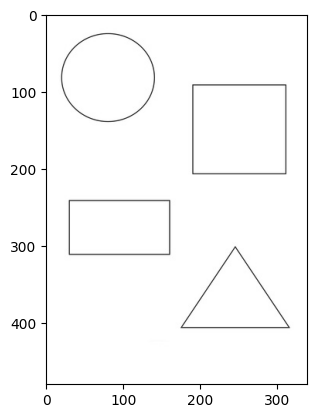

In [76]:
img_shadow_removed = shadow_remove(image)
plt.imshow(img_shadow_removed)

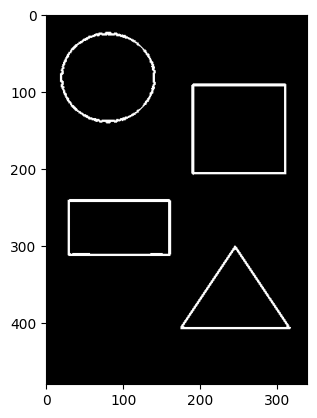

In [77]:
img_preprocess = preprocess(img_shadow_removed)
plt.imshow(img_preprocess)

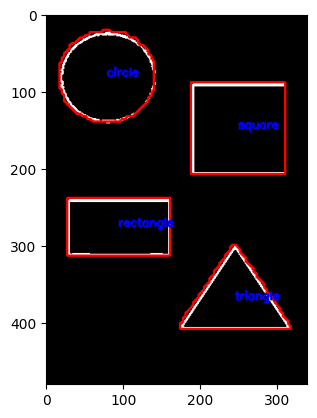

In [78]:
img_shape_detected = shape_detector.detect_shapes(img_preprocess)
plt.imshow(img_shape_detected)